# County-level yield analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import earthpy.clip as ec

import scipy.stats as ss
from sklearn.metrics import r2_score

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/cork/cork.txt")[::-1]
cork_map = LinearSegmentedColormap.from_list("Broc", cm_data)
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/batlow/batlow.txt")
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

## Everything we need

### USDA ground truth

In [2]:
usda = pd.read_csv("../../model_results/output/USDA_county_yields_w_county_trends.csv")
usda["state_fips_code"] = usda["state_fips_code"].astype(str).str.zfill(2)
usda["county_code"] = usda["county_code"].astype(str).str.zfill(3)
usda["GEOID"] = usda["state_fips_code"] + usda["county_code"]
del usda["state_fips_code"]
del usda["county_code"]
usda["asd_code"] = usda["asd_code"].astype(str)

### County shapefile

In [3]:
# Get county shapefile
county = gp.read_file("../../../large_files/contig_county/counties_contig.shp")
county["GEOID"] = county["GEOID"].astype(str).str.zfill(5)

In [4]:
states = gp.read_file("../../../large_files/contig_states/CONUS_states.shp")

In [5]:
coast = gp.read_file("../../../data/conus_dissolved/usa-boundary-dissolved.shp")

### Analysis functions

In [6]:
def analyse_rmse(data):
    # Merge with USDA
    data_all = pd.merge(data.reset_index(), usda.filter(["target_Value", "GEOID", "year", "Value"]), left_on = ["GEOID", "Year"], right_on = ["GEOID", "year"], how = "inner", copy = False)

    del data_all["year"]
    data_all.set_index(["GEOID","Year"], inplace = True)
    
    # Create new geopandas dataframe for analysis. Only take counties with non-zero yield reported
    data_all = data_all.query("Value > 0.0")
    del data_all["Value"]
    data_all["count"] = 1
    
    # Calculate RMSE
    models = np.delete(data_all.columns.values, [np.where(data_all.columns.values == "target_Value"), np.where(data_all.columns.values == "count")])
    for model in models:
        model_RMSE = model + "_RMSE"
        data_all[model_RMSE] = (data_all[model] - data_all["target_Value"])**2
        
        del data_all[model]
        
    data_an = data_all.groupby("GEOID").sum().drop(columns = "target_Value")
    
    # Take only counties with > 40 observations
    data_an = data_an.query("count >= 40")
    for model in models:
        model_RMSE = model + "_RMSE"
        data_an[model_RMSE] = data_an[model_RMSE] / data_an["count"]
        data_an[model_RMSE] = np.sqrt(data_an[model_RMSE])
    
    del data_an["count"]
    return data_an

def analyse_r2(data):
    # Merge with USDA
    data_all = pd.merge(data.reset_index(), usda.filter(["target_Value", "GEOID", "year", "Value"]), left_on = ["GEOID", "Year"], right_on = ["GEOID", "year"], how = "inner", copy = False)

    del data_all["year"]
    data_all.set_index(["GEOID","Year"], inplace = True)
    
    # Create new geopandas dataframe for analysis. Only take counties with non-zero yield reported
    data_all = data_all.query("Value > 0.0")
    del data_all["Value"]
    data_all["count"] = 1
    
    # Calculate Pearson R
    models = np.delete(data_all.columns.values, [np.where(data_all.columns.values == "target_Value"), np.where(data_all.columns.values == "count")])
    for model in models:
        model_R2 = model + "_R2"
        data_all[model_R2] = 0.0
        for geoid in data_all.index.unique(level = "GEOID"):
            if len(data_all.loc[geoid]) >= 10:
                data_all.loc[geoid, model_R2] = ss.pearsonr(data_all.loc[geoid]["target_Value"], data_all.loc[geoid][model])[0]
            else:
                data_all.drop(geoid, inplace = True)
        del data_all[model]
        
    data_an = data_all.groupby("GEOID").sum().drop(columns = "target_Value")
    
    # Take only counties with > 40 observations
    data_an = data_an.query("count >= 40")
    for model in models:
        model_R2 = model + "_R2"
        data_an[model_R2] = data_an[model_R2] / data_an["count"]
    
    del data_an["count"]
    return data_an

## GMFD Analysis

In [7]:
# GMFD
gmfd = pd.read_csv("../../model_results/output/GMFD/yield_historical_gmfd_offset.csv")
gmfd["GEOID"] = gmfd["GEOID"].astype(str).str.zfill(5)

In [8]:
# Pre-process, NOTE we choose here only up to 2005 so to match the NEX/CMIP models
gmfd = gmfd.query("projected != 0.0")
gmfd = gmfd.query("Year <= 2005")
del gmfd["projected"]

In [10]:
gmfd_an = analyse_rmse(gmfd)

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
# Corn Belt states
corn_belt_fips = ["17","18","19","20","26","27","29","31","38","39","46","55"]

In [12]:
# Select only corn belt states
gmfd["fips"] = gmfd["GEOID"].str[:2]
gmfd = gmfd[gmfd["fips"].isin(corn_belt_fips)]

In [13]:
coast = coast.to_crs({'init': 'epsg:4269'})

In [137]:
# Merge with county shapefile
coast = coast.to_crs({'init': 'epsg:4269'})
gmfd_shp = pd.merge(county, gmfd_an, on = "GEOID", how = "outer", copy = False)
gmfd_shp = ec.clip_shp(gmfd_shp, coast.envelope)
gmfd_shp = gp.overlay(gmfd_shp, states, how = "intersection")

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/geopandas/base.py:35: UserWarning: GeoSeries crs mismatch: None and {'init': 'epsg:2163'}
  right.crs))


In [138]:
gmfd_shp.crs = {'init': 'epsg:4269'}

In [ ]:
# Update CRS for better US shape
gmfd_shp = gmfd_shp.to_crs({'init': 'epsg:2163'})
coast = coast.to_crs({'init': 'epsg:2163'})
states = states.to_crs({'init': 'epsg:2163'})

In [148]:
# Clip 
gmfd_shp = ec.clip_shp(gmfd_shp, coast.envelope)
gmfd_shp = gp.overlay(gmfd_shp, states, how = "intersection")

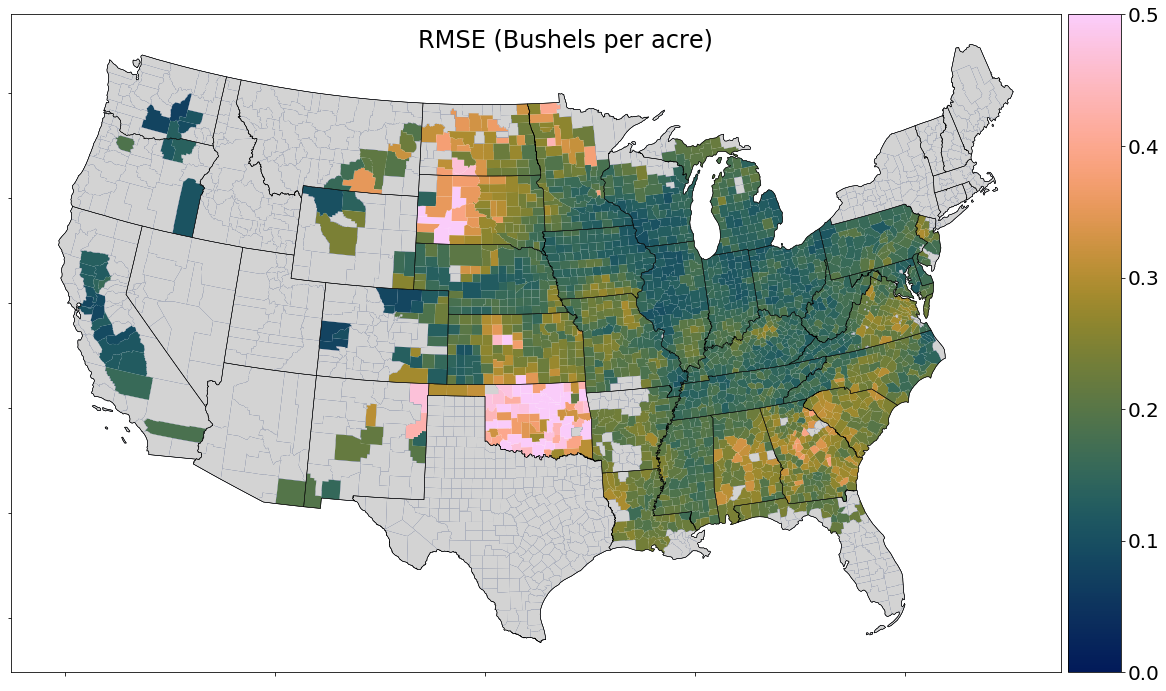

In [150]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gmfd_shp.plot(column = "projected_offset_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map, vmin = 0.0, vmax = 0.5)
gmfd_shp[gmfd_shp.projected_offset_RMSE.isna()].plot(ax = ax, color = "lightgray")
# ax.set_xlim(0, -80)
# ax.set_ylim(35, 50)
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("RMSE (Bushels per acre)", y = 0.94)
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.savefig("map_hind_rmse.png", dpi = 500)

## Hindcasts

In [14]:
nex_hind = ["yield_historical_r1i1p1_ACCESS1-0.csv",
"yield_historical_r1i1p1_BNU-ESM.csv",
"yield_historical_r1i1p1_CCSM4.csv",
"yield_historical_r1i1p1_CESM1-BGC.csv",
"yield_historical_r1i1p1_CNRM-CM5.csv",
"yield_historical_r1i1p1_CSIRO-Mk3-6-0.csv",
"yield_historical_r1i1p1_CanESM2.csv",
"yield_historical_r1i1p1_GFDL-CM3.csv",
"yield_historical_r1i1p1_GFDL-ESM2G.csv",
"yield_historical_r1i1p1_GFDL-ESM2M.csv",
"yield_historical_r1i1p1_IPSL-CM5A-LR.csv",
"yield_historical_r1i1p1_IPSL-CM5A-MR.csv",
"yield_historical_r1i1p1_MIROC-ESM-CHEM.csv",
"yield_historical_r1i1p1_MIROC-ESM.csv",
"yield_historical_r1i1p1_MIROC5.csv",
"yield_historical_r1i1p1_MPI-ESM-LR.csv",
"yield_historical_r1i1p1_MPI-ESM-MR.csv",
"yield_historical_r1i1p1_MRI-CGCM3.csv",
"yield_historical_r1i1p1_NorESM1-M.csv",
"yield_historical_r1i1p1_bcc-csm1-1.csv",
"yield_historical_r1i1p1_inmcm4.csv"]

cmip_all = ["yield_ACCESS1-0.historical+rcp85.csv",
"yield_BNU-ESM.historical+rcp85.csv",
"yield_CCSM4_historical+rcp85.csv",
"yield_CESM1-BGC.historical+rcp85.csv",
"yield_CNRM-CM5.historical+rcp85.csv",
"yield_CSIRO-Mk3-6-0.historical+rcp85.csv",
"yield_CanESM2.historical+rcp85.csv",
"yield_GFDL-CM3.historical+rcp85.csv",
"yield_GFDL-ESM2G.historical+rcp85.csv",
"yield_GFDL-ESM2M.historical+rcp85.csv",
"yield_IPSL-CM5A-LR.historical+rcp85.csv",
"yield_IPSL-CM5A-MR.historical+rcp85.csv",
"yield_MIROC-ESM-CHEM.historical+rcp85.csv",
"yield_MIROC-ESM.historical+rcp85.csv",
"yield_MIROC5.historical+rcp85.csv",
"yield_MPI-ESM-LR.historical+rcp85.csv",
"yield_MPI-ESM-MR.historical+rcp85.csv",
"yield_MRI-CGCM3.historical+rcp85.csv",
"yield_NorESM1-M.historical+rcp85.csv",
"yield_bcc-csm1-1_historical+rcp85.csv",
"yield_inmcm4.historical+rcp85.csv"]

In [15]:
gmfd.head()

,GEOID,Year,projected_offset,fips
31977,17001,1960,0.059899,17
31978,17001,1961,0.001423,17
31979,17001,1962,0.017819,17
31980,17001,1963,-0.020575,17
31981,17001,1964,-0.076620,17


In [16]:
def analyse_RMSE_gmfd(data):
    # Merge with gmfd
    data_all = pd.merge(data.reset_index(), gmfd.dropna(), left_on = ["GEOID", "Year"], right_on = ["GEOID", "Year"], how = "inner", copy = False)

    data_all.set_index(["GEOID","Year"], inplace = True)
    
    # Create new geopandas dataframe for analysis. Only take counties with non-zero yield reported
#     data_all = data_all.query("Value > 0.0")
#     del data_all["Value"]
    data_all["count"] = 1
    
    # Calculate Pearson R
    models = np.delete(data_all.columns.values, [np.where(data_all.columns.values == "projected_offset"), np.where(data_all.columns.values == "count")])
    for model in models:
        model_RMSE = model + "_RMSE"
        data_all[model_RMSE] = (data_all[model] - data_all["projected_offset"])**2
        
        del data_all[model]
        
    data_an = data_all.groupby("GEOID").sum().drop(columns = "projected_offset")
    
    # Take only counties with > 40 observations
    data_an = data_an.query("count >= 40")
    for model in models:
        model_RMSE = model + "_RMSE"
        data_an[model_RMSE] = data_an[model_RMSE] / data_an["count"]
        data_an[model_RMSE] = np.sqrt(data_an[model_RMSE])
    
    del data_an["count"]
    return data_an

In [17]:
nex  = pd.read_csv("../../model_results/output/NEX/res_" + nex_hind[0])
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
nex = nex[nex.projected != 0.0]
nex = nex[nex.Year <= 2005]
del nex["projected"]
nex.rename(columns = {"projected_offset" : nex_hind[0].replace("historical_r1i1p1_","").replace(".csv","").replace("yield_","")}, inplace = True)

In [18]:
nex.head()

,GEOID,Year,ACCESS1-0
0,01001,1950,-0.130307
1,01001,1951,-0.109263
2,01001,1952,-0.307460
3,01001,1953,0.141319
4,01001,1954,-0.150892


In [66]:
# Get nex models
nex  = pd.read_csv("../../model_results/output/NEX/res_" + nex_hind[0])
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
nex = nex[nex.projected != 0.0]
nex = nex[nex.Year <= 2005]
del nex["projected"]
nex.rename(columns = {"projected_offset" : nex_hind[0].replace("historical_r1i1p1_","").replace(".csv","").replace("yield_","")}, inplace = True)

for name in nex_hind[1:]:
    # Read in product
    data = pd.read_csv("../../model_results/output/nex/res_" + name)
    data = data[data.projected != 0.0]
    data = data[data.Year <= 2005]
    del data["projected"]
    data["GEOID"] = data["GEOID"].astype(str).str.zfill(5)
    # Model name
    model = name.replace("historical_r1i1p1_","").replace(".csv","").replace("yield_","")
    data.rename(columns = {"projected_offset" : model}, inplace = True)
    # Do the merge
    print("Read in: " + model + ". Shape: " + str(data.shape) + ". Merging now...")
    nex = pd.merge(nex, data, on = ["GEOID", "Year"], how = "outer")
    print("Merge complete. New shape: " + str(nex.shape))
    
# Drop NaNs and zeros (they are all at the same location)
nex.dropna(inplace = True)
nex = nex[nex.inmcm4 != 0]

# Add ensemble mean
nex.set_index(["GEOID", "Year"], inplace = True)
nex["ensemble_mean"] = nex.mean(axis = 1)

# Calculate RMSE with USDA
nex_an = analyse_rmse(nex)
# Get RMSE stats
nex_an["RMSE_mean"] = nex_an.drop(columns = "ensemble_mean_RMSE").mean(axis=1)
# Merge with county shapefile
nex_shp = pd.merge(county, nex_an, on = "GEOID", how = "outer", copy = False)

# Calculate RMSE with GMFD
nex_gmfd_an = analyse_RMSE_gmfd(nex)
# Get R stats
nex_gmfd_an["RMSE_mean"] = nex_gmfd_an.drop(columns = "ensemble_mean_RMSE").mean(axis = 1)
# Merge with county shapefile
nex_gmfd_shp = pd.merge(county, nex_gmfd_an, on = "GEOID", how = "outer", copy = False)

Read in: BNU-ESM. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 4)
Read in: CCSM4. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 5)
Read in: CESM1-BGC. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 6)
Read in: CNRM-CM5. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 7)
Read in: CSIRO-Mk3-6-0. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 8)
Read in: CanESM2. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 9)
Read in: GFDL-CM3. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 10)
Read in: GFDL-ESM2G. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 11)
Read in: GFDL-ESM2M. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 12)
Read in: IPSL-CM5A-LR. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 13)
Read in: IPSL-CM5A-MR. Shape: (154224, 3). Merging now...

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
# Get cmip models
cmip  = pd.read_csv("../../model_results/output/CMIP/res_" + cmip_all[0])
cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)
cmip = cmip[cmip.projected != 0.0]
cmip = cmip[cmip.Year <= 2005]
del cmip["projected"]
cmip.rename(columns = {"projected_offset" : cmip_all[0].replace("historical+rcp85.","").replace(".csv","").replace("yield_","")}, inplace = True)

for name in cmip_all[1:]:
    # Read in product
    data = pd.read_csv("../../model_results/output/CMIP/res_" + name)
    data = data[data.projected != 0.0]
    data = data[data.Year <= 2005]
    del data["projected"]
    data["GEOID"] = data["GEOID"].astype(str).str.zfill(5)
    # Model name
    model = name.replace(".historical+rcp85","").replace(".csv","").replace("yield_","")
    data.rename(columns = {"projected_offset" : model}, inplace = True)
    # Do the merge
    print("Read in: " + model + ". Shape: " + str(data.shape) + ". Merging now...")
    cmip = pd.merge(cmip, data, on = ["GEOID", "Year"], how = "outer")
    print("Merge complete. New shape: " + str(cmip.shape))
    
# Drop NaNs and zeros (they are all at the same location)
cmip.dropna(inplace = True)
cmip = cmip[cmip.inmcm4 != 0]

# Add ensemble mean
cmip.set_index(["GEOID", "Year"], inplace = True)
cmip["ensemble_mean"] = cmip.mean(axis = 1)

# Calculate RMSEs
cmip_an = analyse_rmse(cmip)
# Get RMSE stats
cmip_an["RMSE_mean"] = cmip_an.drop(columns = "ensemble_mean_RMSE").mean(axis=1)
# Merge with county shapefile
cmip_shp = pd.merge(county, cmip_an, on = "GEOID", how = "outer", copy = False)

# Calculate RMSE with GMFD
cmip_gmfd_an = analyse_RMSE_gmfd(cmip)
# Get R stats
cmip_gmfd_an["RMSE_mean"] = cmip_gmfd_an.drop(columns = "ensemble_mean_RMSE").mean(axis = 1)
# Merge with county shapefile
cmip_gmfd_shp = pd.merge(county, cmip_gmfd_an, on = "GEOID", how = "outer", copy = False)

Read in: BNU-ESM. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 4)
Read in: CCSM4_historical+rcp85. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 5)
Read in: CESM1-BGC. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 6)
Read in: CNRM-CM5. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 7)
Read in: CSIRO-Mk3-6-0. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 8)
Read in: CanESM2. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 9)
Read in: GFDL-CM3. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 10)
Read in: GFDL-ESM2G. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 11)
Read in: GFDL-ESM2M. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 12)
Read in: IPSL-CM5A-LR. Shape: (154224, 3). Merging now...
Merge complete. New shape: (154224, 13)
Read in: IPSL-CM5A-MR. Shape: (154224, 3

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
# Update CRS for better US shape
nex_shp = nex_shp.to_crs({'init': 'epsg:2163'})
cmip_shp = cmip_shp.to_crs({'init': 'epsg:2163'})
coast = coast.to_crs({'init': 'epsg:2163'})
states = states.to_crs({'init': 'epsg:2163'})

# Clip 
nex_shp = ec.clip_shp(nex_shp, coast.envelope)
nex_shp.crs = {'init': 'epsg:2163'}
nex_shp = gp.overlay(nex_shp, states, how = "intersection")

cmip_shp = ec.clip_shp(cmip_shp, coast.envelope)
cmip_shp.crs = {'init': 'epsg:2163'}
cmip_shp = gp.overlay(cmip_shp, states, how = "intersection")

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


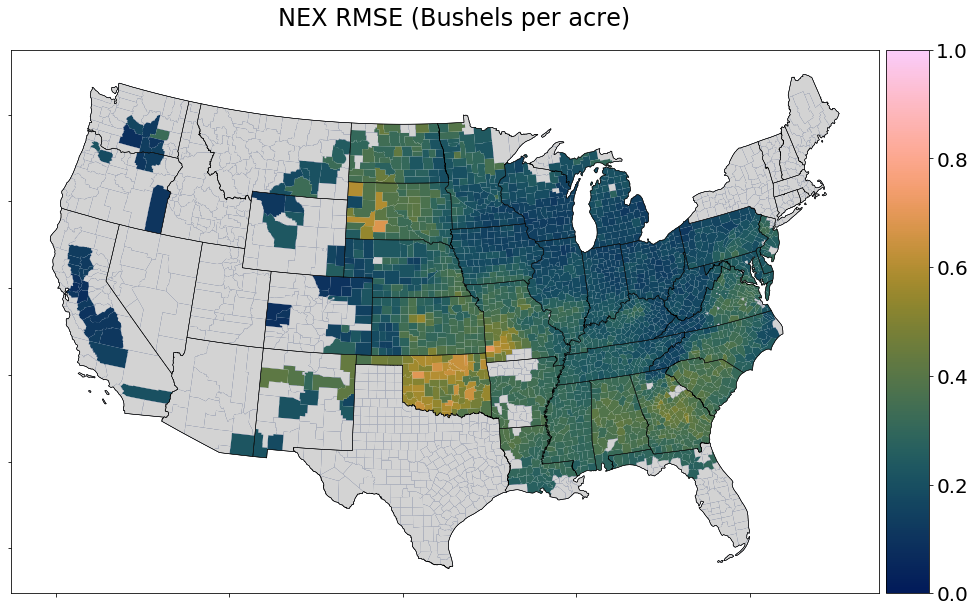

In [45]:
# NEX
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
nex_shp.plot(column = "RMSE_mean", ax = ax, cax = cax, legend = True, vmin = 0.0, vmax = 1.0, cmap = batlow_map)
nex_shp[nex_shp.RMSE_mean.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("NEX RMSE (Bushels per acre)", y = 0.94)
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

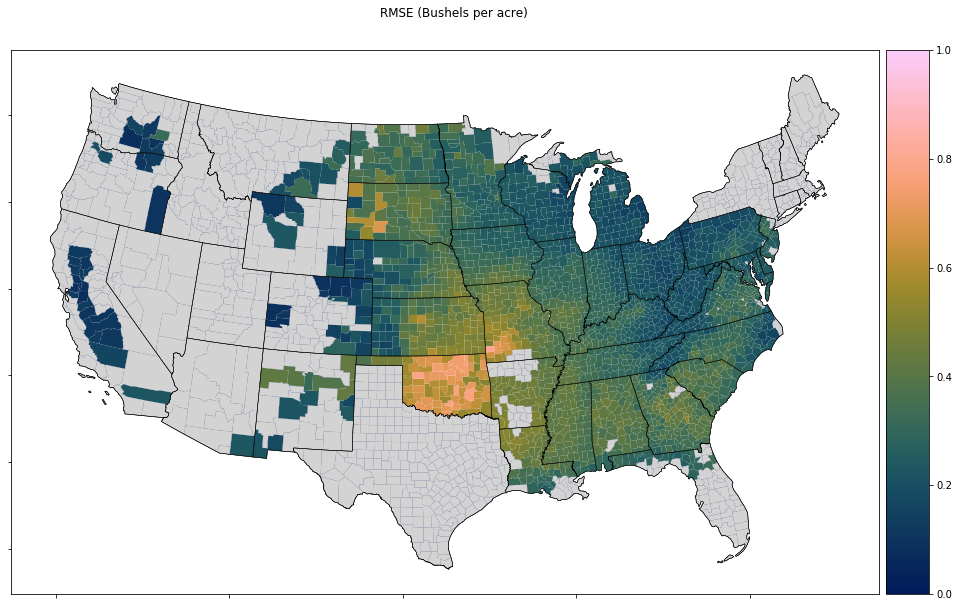

In [27]:
# CMIP
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmip_shp.plot(column = "RMSE_mean", ax = ax, cax = cax, legend = True, vmin = 0.0, vmax = 1.0, cmap = batlow_map)
cmip_shp[cmip_shp.RMSE_mean.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("RMSE (Bushels per acre)", y = 0.94)
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

In [46]:
# NEX to CMIP ratios against USDA
all_shp = pd.merge(nex_shp.filter(["RMSE_mean", "GEOID", "geometry", "ensemble_mean_RMSE"]), cmip_shp.filter(["RMSE_mean", "GEOID", "ensemble_mean_RMSE"]), on = ["GEOID"], suffixes=("_NEX", "_CMIP"))
all_shp["RMSE_mean_ratio"] = all_shp["RMSE_mean_NEX"] / all_shp["RMSE_mean_CMIP"]
all_shp["ensemble_mean_RMSE_ratio"] = all_shp["ensemble_mean_RMSE_NEX"] / all_shp["ensemble_mean_RMSE_CMIP"]

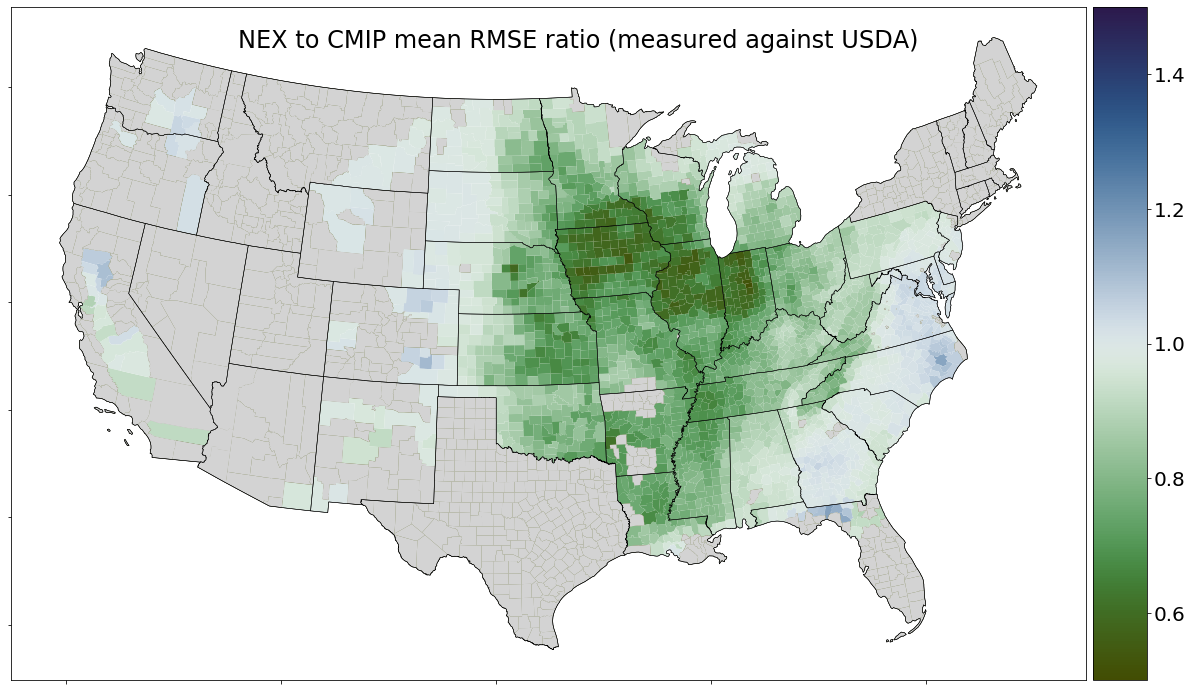

In [47]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.plot(column = "RMSE_mean_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.5, vmax = 1.5)
all_shp[all_shp.RMSE_mean_ratio.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("NEX to CMIP mean RMSE ratio (measured against USDA)", y = 0.94)
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.show()
# plt.savefig("map_hind_rmse_ratio_USDA.png", dpi = 500)

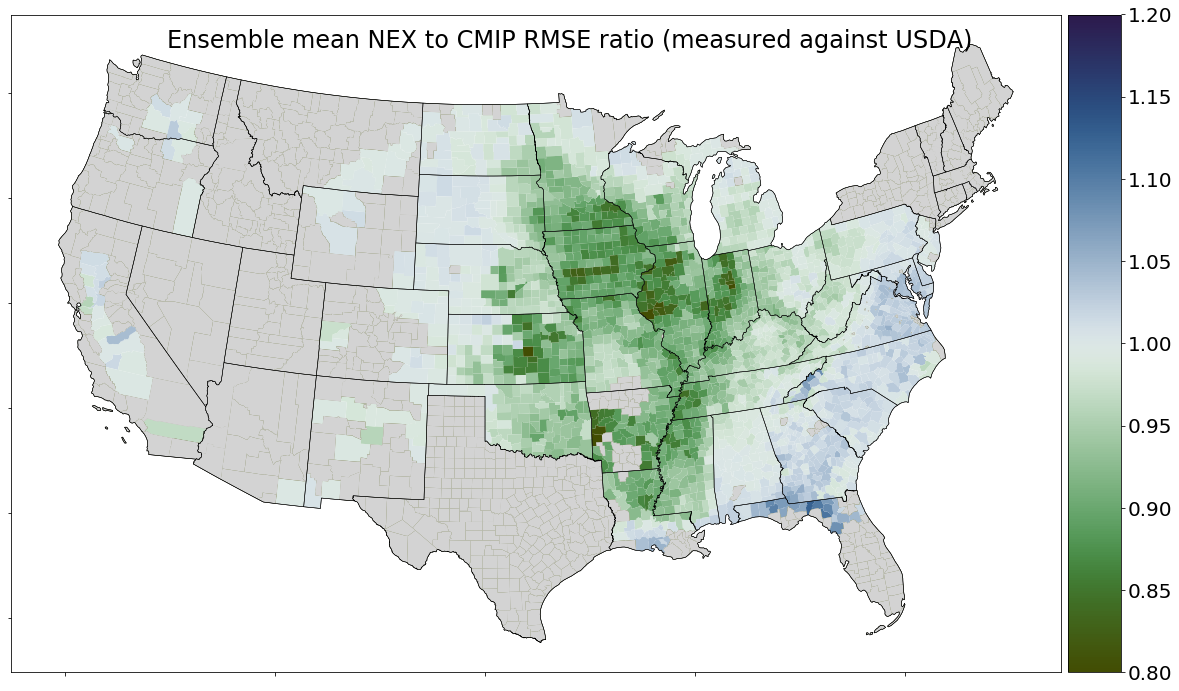

In [48]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.plot(column = "ensemble_mean_RMSE_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.8, vmax = 1.2)
all_shp[all_shp.ensemble_mean_RMSE_ratio.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("Ensemble mean NEX to CMIP RMSE ratio (measured against USDA)", y = 0.94)
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
# plt.savefig("map_hind_ens_mean_rmse_ratio_USDA.png", dpi = 500)
plt.show()

In [84]:
######################################################## GMFD

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


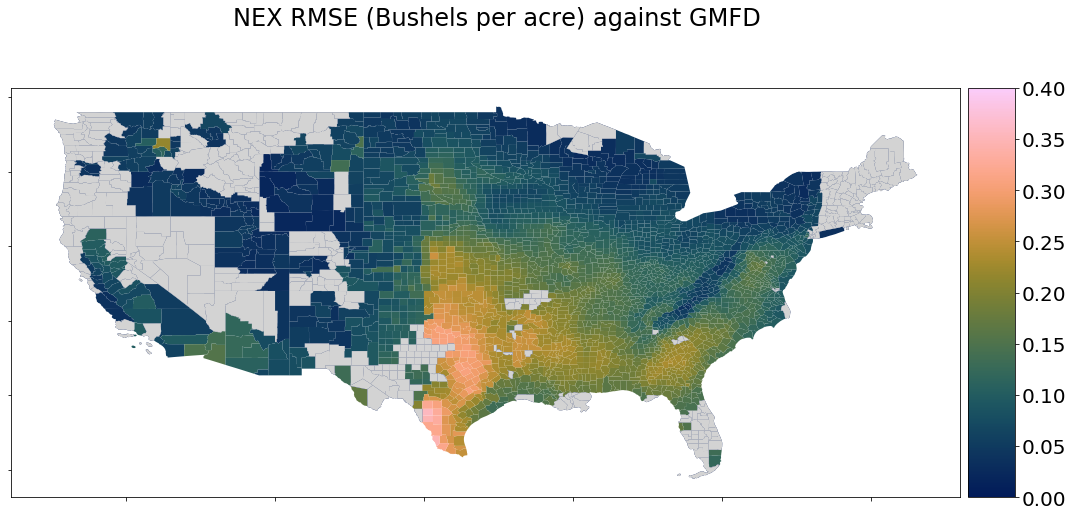

In [89]:
# NEX
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# nex_gmfd_shp.plot(column = "RMSE_mean", ax = ax, cax = cax, legend = True, cmap = batlow_map)
# nex_gmfd_shp[nex_gmfd_shp.RMSE_mean.isna()].plot(ax = ax, color = "lightgray")

nex_gmfd_shp.plot(column = "ensemble_mean_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map, vmin = 0.0, vmax = 0.4)
nex_gmfd_shp[nex_gmfd_shp.ensemble_mean_RMSE.isna()].plot(ax = ax, color = "lightgray")

ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("NEX RMSE (Bushels per acre) against GMFD", y = 0.9)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

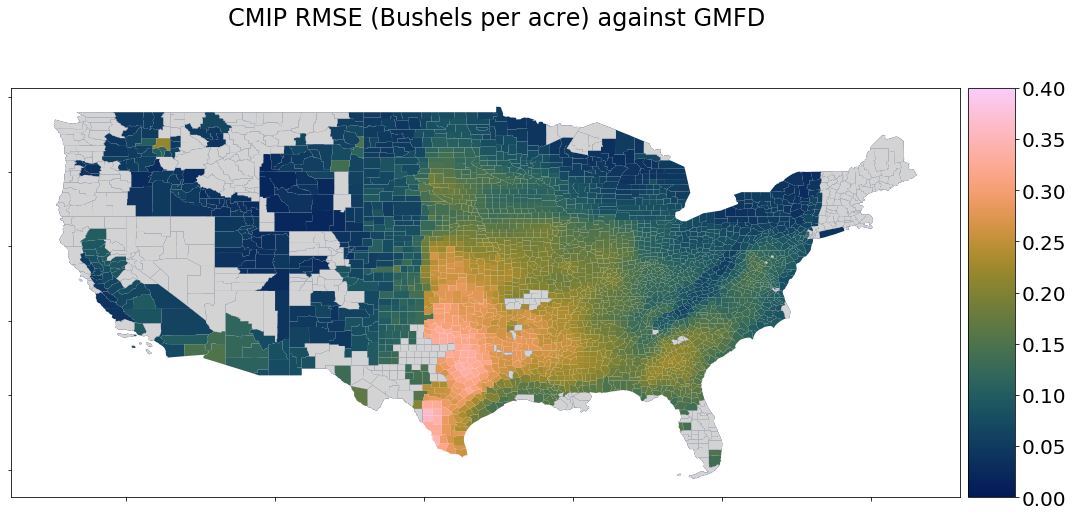

In [90]:
# CMIP
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# cmip_gmfd_shp.plot(column = "RMSE_mean", ax = ax, cax = cax, legend = True, cmap = batlow_map)
# cmip_gmfd_shp[cmip_gmfd_shp.RMSE_mean.isna()].plot(ax = ax, color = "lightgray")

cmip_gmfd_shp.plot(column = "ensemble_mean_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map, vmin = 0.0, vmax = 0.4)
cmip_gmfd_shp[cmip_gmfd_shp.ensemble_mean_RMSE.isna()].plot(ax = ax, color = "lightgray")

ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("CMIP RMSE (Bushels per acre) against GMFD", y = 0.9)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

In [91]:
# NEX to CMIP ratios against GMFD
all_shp_gmfd = pd.merge(nex_gmfd_shp.filter(["RMSE_mean", "GEOID", "geometry", "ensemble_mean_RMSE"]), cmip_gmfd_shp.filter(["RMSE_mean", "GEOID", "ensemble_mean_RMSE"]), on = ["GEOID"], suffixes=("_NEX", "_CMIP"))
all_shp_gmfd["RMSE_mean_ratio"] = all_shp_gmfd["RMSE_mean_NEX"] / all_shp_gmfd["RMSE_mean_CMIP"]
all_shp_gmfd["ensemble_mean_RMSE_ratio"] = all_shp_gmfd["ensemble_mean_RMSE_NEX"] / all_shp_gmfd["ensemble_mean_RMSE_CMIP"]

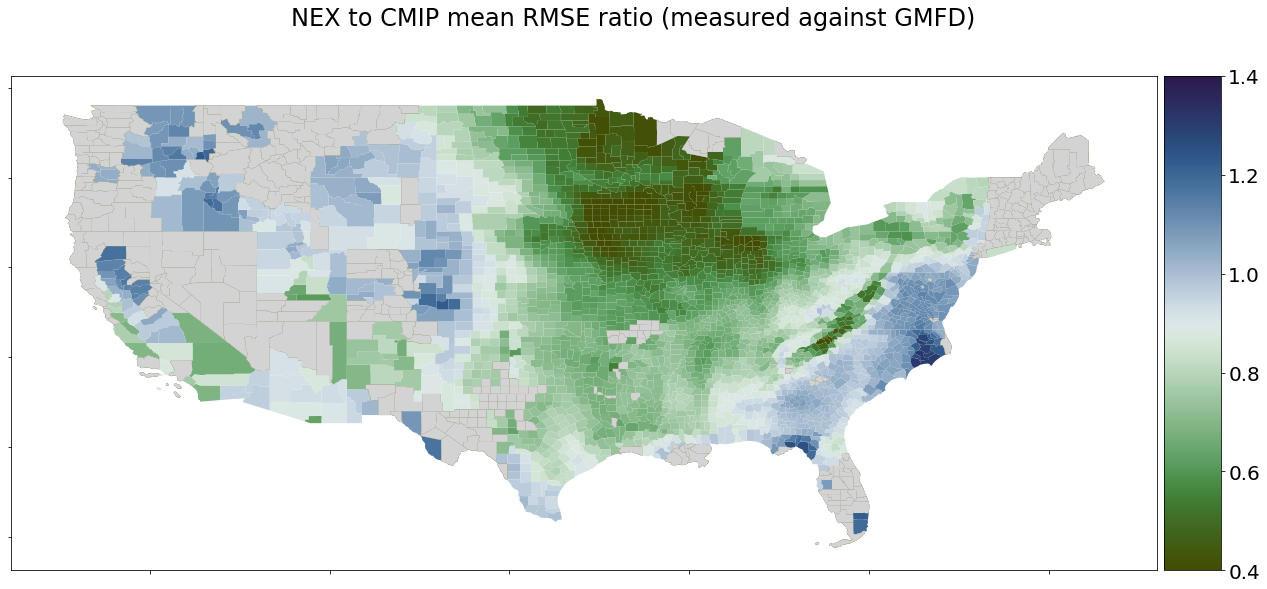

In [94]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp_gmfd.plot(column = "RMSE_mean_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.4, vmax = 1.4)
all_shp_gmfd[all_shp_gmfd.RMSE_mean_ratio.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("NEX to CMIP mean RMSE ratio (measured against GMFD)", y = 0.94)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
# plt.savefig("map_hind_ens_mean_rmse_ratio_USDA.png", dpi = 500)
plt.show()

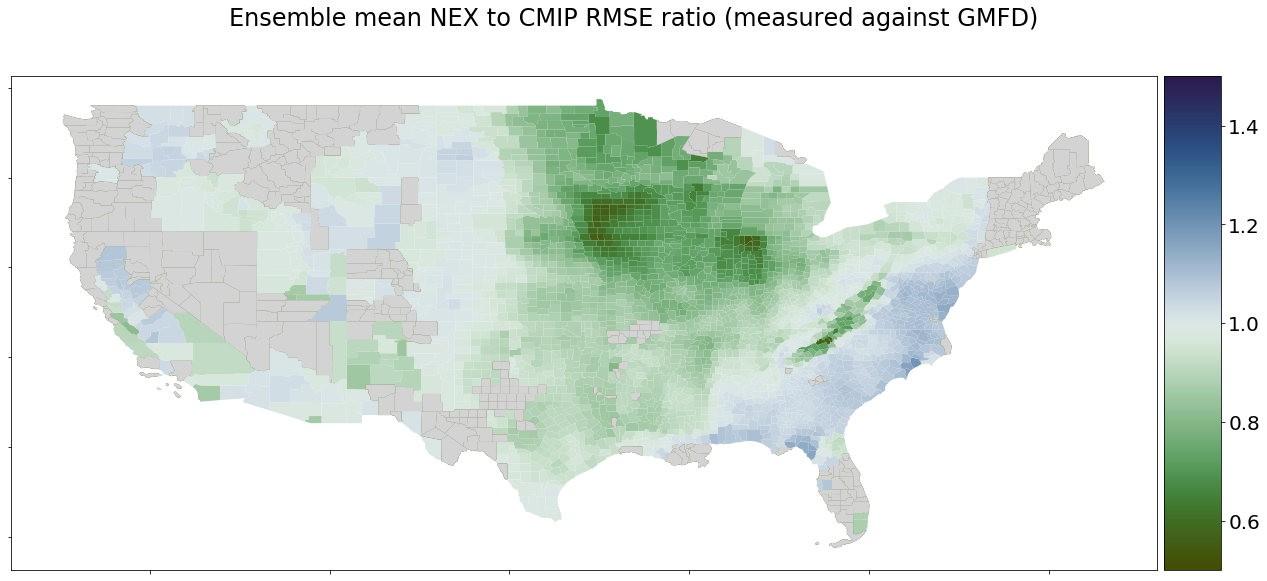

In [97]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp_gmfd.plot(column = "ensemble_mean_RMSE_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.5, vmax = 1.5)
all_shp_gmfd[all_shp_gmfd.ensemble_mean_RMSE_ratio.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
fig.suptitle("Ensemble mean NEX to CMIP RMSE ratio (measured against GMFD)", y = 0.94)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
# plt.savefig("map_hind_ens_mean_rmse_ratio_USDA.png", dpi = 500)
plt.show()